# VSA Non Flatten Bundle
- In this notebook we explore what happens when we don't flatten the bundle. But instead, we do a similarity search again while saving the magnitude of each element. 
- Take note, that this is only applicable for the non-binary implementations as binary strictly needs the Hamming distance.

In [1]:
# Import library
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

# Gets directory where script was launched from
script_dir = os.getcwd()  
script_dir = script_dir + "/../lib/"
print(f"VSA Library: {script_dir}")

# Add the directory to Python's search path
sys.path.append(script_dir)  

import vsa as vsa
import vsa_func as vsaf
import vsa_profile as vsap

VSA Library: \\wsl.localhost\Ubuntu\home\rantonio\chronomatica\vsa/../lib/


- First, we replicate the functions made from [VSA Recall Datatypes](./vsa_recall_datatypes.ipynb) which is to plot the variance and mean for each bundle distribution.

In [2]:
# Parameters to modify
HV_DIM = 1024
# Use odd number NUM_ITEMS to avoid ties when bundling
NUM_ITEMS = 501
THRESHOLD = NUM_ITEMS / 2
NUM_TRIALS = 1000
HV_DIM_LIST = [1024, 2048, 4096, 8192]

- The code below is the same as the previous one except that the sum now disables the flatten flag.

In [3]:
def im_bundle_scores(num_trials, num_items, hv_dim, disable_tqdm=False, im_type="binary", int_min=-128, int_max=127):
    # Just re-do this for the sake of making elements
    x = np.arange(3, num_items+1, 2)
    score_matrix  = np.zeros((num_trials, len(x)))
    # Iterate through different trial so we average thme out later
    for trial in tqdm.tqdm(range(num_trials), desc="Trials", disable=disable_tqdm):
        if (im_type == "integer"):
            im = vsaf.gen_orthogonal_im(num_items, hv_dim, type=im_type, int_min=-128, int_max=127)
        else:
            im = vsaf.gen_orthogonal_im(num_items, hv_dim, type=im_type)

        # Iterate through different bundle sizes
        for i, bundle_num in enumerate(x):
            if im_type =="binary":
                threshold = bundle_num / 2
                bundled_im = vsa.hv_add(im[0:bundle_num], threshold=threshold)
                score_matrix[trial, i] = vsa.hv_ham(im[0], bundled_im)
            else:
                # NOTICE ME! DONT FLATTEN!
                bundled_im = vsa.hv_add(im[0:bundle_num], dont_flatten=True)
                score_matrix[trial, i] = vsa.hv_cos(im[0], bundled_im)
    return score_matrix

In [4]:
def plot_dimension_change(x, hv_dim_list, mean_trend, stddev_trend, func_mean_var, subplot_shape, xytext_offset=(5,10), set_ylim=(0.5,0.6), im_type="binary"):

    # Some base variables and settings
    alpha = 0.4
    row_idx = 0
    col_idx = 0
    max_rows, max_cols = subplot_shape

    # Set figure size
    fig, axes = plt.subplots(max_rows, max_cols, figsize=(10, 10), dpi=100)

    for i, D in enumerate(hv_dim_list):
        row_idx = i // max_cols
        col_idx = i % max_cols

        mu, std, _ = func_mean_var(D)

        # Create a line for the mean and sim cut score
        if im_type == "binary":
            mu_line = np.array([mu/D] * len(x))
            std_line = np.array([3*std/D] * len(x))
        else:
            mu_line = np.array([mu] * len(x))
            std_line = np.array([3*std] * len(x))

        # Plot ideal mean and std lines
        if im_type == "binary":
            axes[row_idx, col_idx].plot(x, mu_line, color='green', label=f"Theoretical $\mu$ = {mu/D:.3f}" )
            axes[row_idx, col_idx].fill_between(x, mu_line - std_line, mu_line + std_line, alpha=0.2, color='green', label=f"Theoretical $3\sigma$ = {3*std/D:.3f}" )
        else:
            axes[row_idx, col_idx].plot(x, mu_line, color='green', label=f"Theoretical $\mu$ = {mu:.3f}" )
            axes[row_idx, col_idx].fill_between(x, mu_line - std_line, mu_line + std_line, alpha=0.2, color='green', label=f"Theoretical $3\sigma$ = {3*std:.3f}" )


        # Get cut for the score
        if im_type == "binary":
            sim_cut_score = np.array([(mu + 3*std) / D] * len(x))
        else:
            sim_cut_score = np.array([(mu + 3*std)] * len(x))

        # Highlight point of intersection between the sim_cut_score and mean_vec
        intersection_index = np.where((mean_trend[D] - 3*stddev_trend[D]) >= sim_cut_score)[0][-1]
        # Plot point of intersection only
        axes[row_idx, col_idx].plot(x[intersection_index], (mean_trend[D] - 3*stddev_trend[D])[intersection_index], 'o', color='blue')
        # Plot cross line
        sim_cut_actual_score = [(mean_trend[D] - 3*stddev_trend[D])[intersection_index]]*len(x)
        axes[row_idx, col_idx].plot(x, sim_cut_actual_score, linestyle='--', color='gray' )
        axes[row_idx, col_idx].axvline(x[intersection_index], linestyle='--', color='gray')

        axes[row_idx, col_idx].annotate(
            f"({x[intersection_index]}, {mean_trend[D][intersection_index]:.3f})",
            xy=(x[intersection_index], (mean_trend[D] - stddev_trend[D])[intersection_index]),
            xytext=xytext_offset,  # offset in points (x, y)
            textcoords="offset points",
            fontsize=12,
            ha="left",
            va="bottom"
        )
        # Plot the points
        axes[row_idx, col_idx].plot( x, mean_trend[1024], 
                        linewidth=2, color="red",
                        label=f"Empirical $\mu$ = {mean_trend[D][intersection_index]:.3f}")
        axes[row_idx, col_idx].fill_between( 
            x, 
            mean_trend[D] - 3*stddev_trend[D], 
            mean_trend[D] + 3*stddev_trend[D], 
            alpha=alpha,
            label=f"Empirical $3\sigma$ = {3*stddev_trend[D][intersection_index]:.3f}"
        )
        axes[row_idx, col_idx].set_title(f"D={D}")
        axes[row_idx, col_idx].set_ylim(set_ylim)
        axes[row_idx, col_idx].legend()

    # Add labels and title
    plt.xlabel("Bundle Size")
    plt.ylabel("Sim Score")
    plt.show()



In [5]:
def expected_mean_std_var_non_binary(D):
    mu = 0
    var = 1/D
    std = np.sqrt(var)
    return mu, std, var

In [6]:
def calculate_mean_std(score_matrix):
    mean_vec = np.mean(score_matrix, axis=0)
    std_vec = np.std(score_matrix, axis=0)
    return mean_vec, std_vec

In [7]:
bipolar_mean_trend = {}
bipolar_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    bipolar_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="bipolar")
    bipolar_mean_trend[HV_DIM_LIST[i]], bipolar_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(bipolar_score_D)

Dimension:   0%|          | 0/4 [00:00<?, ?it/s]

Dimension: 100%|██████████| 4/4 [15:16<00:00, 229.07s/it]


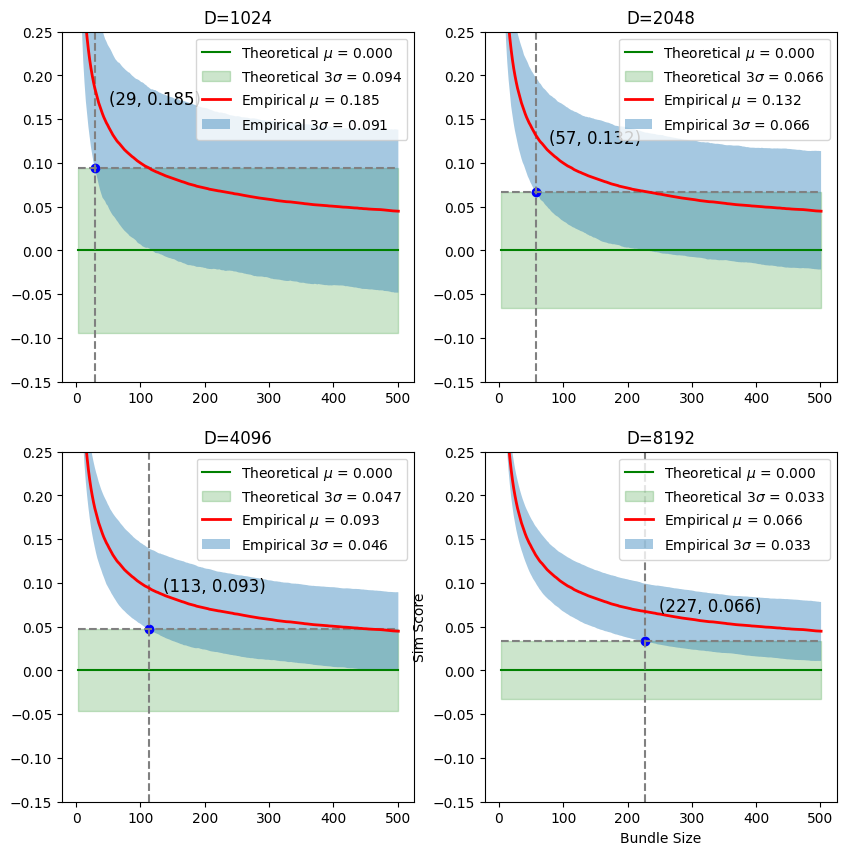

In [8]:
x = np.arange(3, NUM_ITEMS+1, 2)
plot_dimension_change(
    x, 
    HV_DIM_LIST,
    bipolar_mean_trend, 
    bipolar_stddev_trend, 
    expected_mean_std_var_non_binary, 
    subplot_shape=(2,2), 
    xytext_offset=(10,5),
    set_ylim=(-0.15,0.25),
    im_type="bipolar"
)

- Interestingly, the intuition is right, if we use more bit-widths the amount of capacity increases significantly.
- Compare it with the results in the [VSA Recall Datatypes](./vsa_recall_datatypes.ipynb) where the increase is roughly in the range of $1.6\times$ to $1.7\times$.
- Let's test it out with the integer and real numbers.

In [9]:
integer_mean_trend = {}
integer_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    integer_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="integer")
    integer_mean_trend[HV_DIM_LIST[i]], integer_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(integer_score_D)

Dimension: 100%|██████████| 4/4 [09:25<00:00, 141.47s/it]


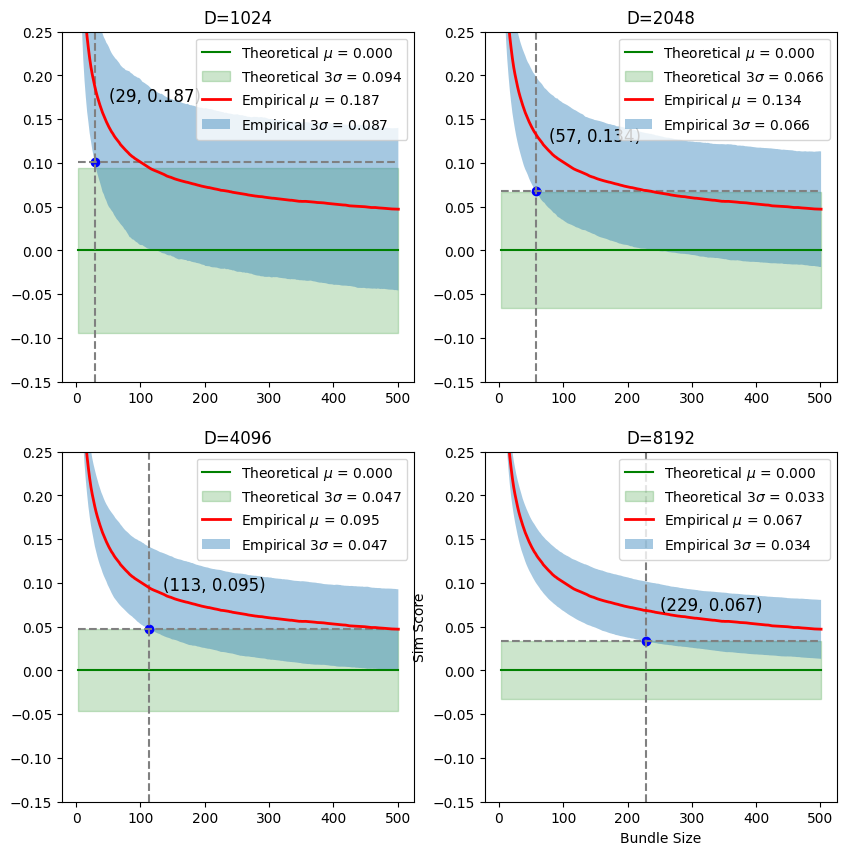

In [10]:
plot_dimension_change(
    x, 
    HV_DIM_LIST,
    integer_mean_trend, 
    integer_stddev_trend, 
    expected_mean_std_var_non_binary, 
    subplot_shape=(2,2), 
    xytext_offset=(10,5),
    set_ylim=(-0.15,0.25),
    im_type="integer"
)

In [11]:
real_mean_trend = {}
real_stddev_trend = {}
for i in tqdm.tqdm(range(len(HV_DIM_LIST)), desc="Dimension"):
    real_score_D = im_bundle_scores(NUM_TRIALS, NUM_ITEMS, HV_DIM_LIST[i], disable_tqdm=True,im_type="real")
    real_mean_trend[HV_DIM_LIST[i]], real_stddev_trend[HV_DIM_LIST[i]] = calculate_mean_std(real_score_D)

Dimension: 100%|██████████| 4/4 [10:28<00:00, 157.05s/it]


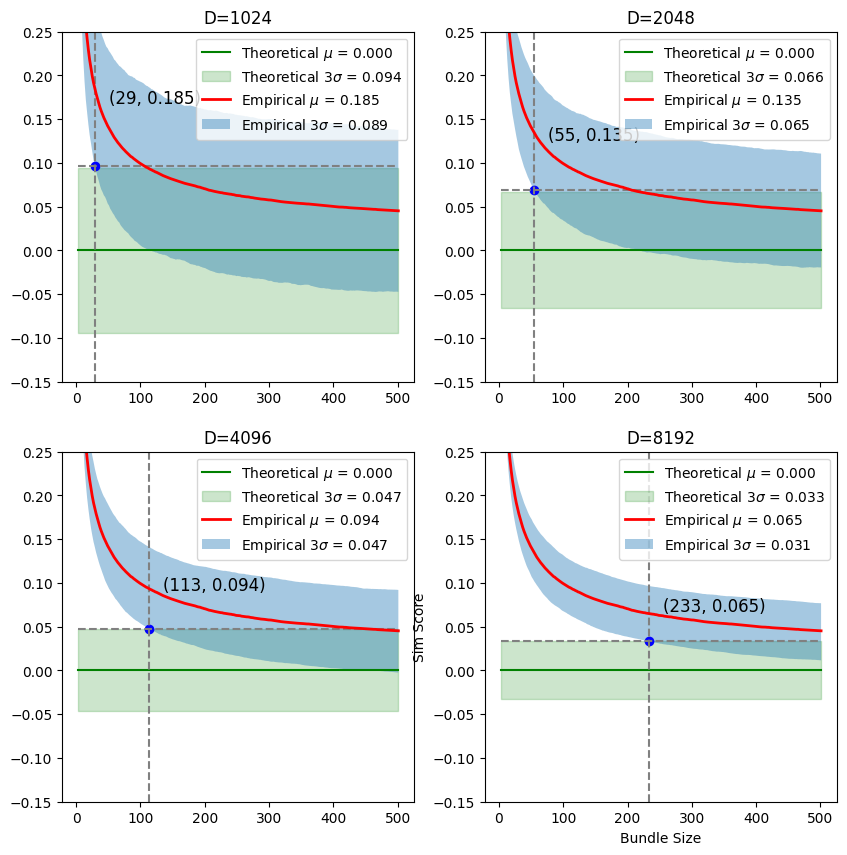

In [12]:
plot_dimension_change(
    x, 
    HV_DIM_LIST,
    real_mean_trend, 
    real_stddev_trend, 
    expected_mean_std_var_non_binary, 
    subplot_shape=(2,2), 
    xytext_offset=(10,5),
    set_ylim=(-0.15,0.25),
    im_type="real"
)

## Conclusion
- The conclusion is simple, with a non-flattened similarity check, we have more information and hence elements are not drowned in noise.